In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
import time

import data_splitter as ds
import data_loader as dl
import feature_extraction as fex
import run_model as rm
import eval_model as ev

2023-04-13 15:09:11.756816: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 15:09:20.787887: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import subprocess

try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected!')
except Exception: # this command not being found can raise quite a few different errors depending on the configuration
    print('No Nvidia GPU in system!')

Nvidia GPU detected!


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
KERASTUNER_TUNER_ID="chief"
KERASTUNER_ORACLE_IP="127.0.0.1"
KERASTUNER_ORACLE_PORT="8000"

In [6]:
splitter = ds.DataSplitter(verbose=True)

Total patient_id in training set:  9530
Total patient_id in test set:  2383
Total image_id in training set:  43767
Total image_id in test set:  10939
Total patient_id in training set:  7624
Total patient_id in calibration set:  1906
Total image_id in training set:  35003
Total image_id in calibration set:  8764


In [7]:
# splitter.trainset is the training set in format of {patient_id: [image_id, ...]}
train_ids = splitter.trainset.keys()
label_by_img = splitter.labels

# getting cross-validation folds from training set
RANDOM_STATE = 42
cv_patient, cv_img = splitter.get_cv(n_splits=5, random_state=RANDOM_STATE)

Splitting training set into 5 stratified k-folds...
--Fold:  0
----Total patient_id in training set:  6099
----Total image_id in training set:  28031
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6972
--Fold:  1
----Total patient_id in training set:  6099
----Total image_id in training set:  28016
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6987
--Fold:  2
----Total patient_id in training set:  6099
----Total image_id in training set:  27937
----Total patient_id in validation set:  1525
----Total image_id in validation set:  7066
--Fold:  3
----Total patient_id in training set:  6099
----Total image_id in training set:  28025
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6978
--Fold:  4
----Total patient_id in training set:  6100
----Total image_id in training set:  28003
----Total patient_id in validation set:  1524
----Total image_id in validation set:  7000


In [8]:
cv_train_by_class = splitter.get_cv_train_img_by_class(cv_img)

--Fold:  0
----Total image_id in training set with class 0:  27450
----Total image_id in training set with class 1:  581
--Fold:  1
----Total image_id in training set with class 0:  27440
----Total image_id in training set with class 1:  576
--Fold:  2
----Total image_id in training set with class 0:  27354
----Total image_id in training set with class 1:  583
--Fold:  3
----Total image_id in training set with class 0:  27440
----Total image_id in training set with class 1:  585
--Fold:  4
----Total image_id in training set with class 0:  27428
----Total image_id in training set with class 1:  575


In [9]:
metadata = pd.read_csv('train.csv')

# Using full training set and control for class ratio at batch level 

### Image Resolution 512 x 512

In [10]:
IMG_SIZE = (512, 512, 1)

inception = keras.applications.InceptionV3(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
    )

inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 255, 255, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 255, 255, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

                                                                                                  
 conv2d_10 (Conv2D)             (None, 61, 61, 96)   82944       ['activation_9[0][0]']           
                                                                                                  
 conv2d_11 (Conv2D)             (None, 61, 61, 32)   6144        ['average_pooling2d[0][0]']      
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 61, 61, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 61, 61, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
          

                                                                  'activation_14[0][0]',          
                                                                  'activation_17[0][0]',          
                                                                  'activation_18[0][0]']          
                                                                                                  
 conv2d_22 (Conv2D)             (None, 61, 61, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_22 (BatchN  (None, 61, 61, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 61, 61, 64)   0           ['batch_normalization_22[0][0]'] 
          

 ormalization)                                                                                    
                                                                                                  
 activation_26 (Activation)     (None, 30, 30, 384)  0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activation_29 (Activation)     (None, 30, 30, 96)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 30, 30, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 30, 30, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
          

 activation_39 (Activation)     (None, 30, 30, 192)  0           ['batch_normalization_39[0][0]'] 
                                                                                                  
 mixed4 (Concatenate)           (None, 30, 30, 768)  0           ['activation_30[0][0]',          
                                                                  'activation_33[0][0]',          
                                                                  'activation_38[0][0]',          
                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 30, 30, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 30, 30, 160)  480        ['conv2d_44[0][0]']              
 ormalizat

                                                                  'activation_49[0][0]']          
                                                                                                  
 conv2d_54 (Conv2D)             (None, 30, 30, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 batch_normalization_54 (BatchN  (None, 30, 30, 160)  480        ['conv2d_54[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 30, 30, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 30, 30, 160)  179200      ['activation_54[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_64 (Activation)     (None, 30, 30, 192)  0           ['batch_normalization_64[0][0]'] 
                                                                                                  
 conv2d_65 (Conv2D)             (None, 30, 30, 192)  258048      ['activation_64[0][0]']          
                                                                                                  
 batch_normalization_65 (BatchN  (None, 30, 30, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 30, 30, 192)  0           ['batch_normalization_65[0][0]'] 
          

                                                                                                  
 batch_normalization_73 (BatchN  (None, 30, 30, 192)  576        ['conv2d_73[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_73 (Activation)     (None, 30, 30, 192)  0           ['batch_normalization_73[0][0]'] 
                                                                                                  
 conv2d_70 (Conv2D)             (None, 30, 30, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 30, 30, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_nor

 batch_normalization_83 (BatchN  (None, 14, 14, 384)  1152       ['conv2d_83[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_84 (Conv2D)             (None, 14, 14, 192)  245760      ['average_pooling2d_7[0][0]']    
                                                                                                  
 batch_normalization_76 (BatchN  (None, 14, 14, 320)  960        ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 activation_87 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_87[0][0]'] 
                                                                                                  
 activation_88 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_88[0][0]'] 
                                                                                                  
 activation_91 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_nor

In [11]:
train_img_ids = cv_img[0]['train']
val_img_ids = cv_img[0]['validate']

In [18]:
BATCH_SIZE = 4*32 
IMG_SIZE = (512, 512, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory storing the preprocessed image of the training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        train_img_by_class = cv_train_by_class[0],
        train_class_ratio = (0.5, 0.5),
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,

        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [19]:
print(len(train_gen), len(val_gen))
X, y = train_gen[0]
print(X.shape, y.shape)

428 54
(128, 512, 512, 3) (128,)


In [20]:
X, y = val_gen[0]
print(X.shape, y.shape)

(128, 512, 512, 3) (128,)


In [21]:
inception.output.shape[-3:]

TensorShape([14, 14, 2048])

## Out of the box

In [22]:
model_layers = keras.Sequential([
    keras.layers.Input(inception.output.shape[-3:]),
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Dense(1, activation='sigmoid')
])

model_layers.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [23]:
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 512, 512, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 sequential_3 (Sequential)   (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [24]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_512_classratio_adam-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 40,
    validation_data=val_gen,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-13 04:02:49.283766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-13 04:03:23.203506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


428/428 [==============================] - ETA: 0s - loss: 0.6932 - tp: 8832.0000 - fp: 8832.0000 - tn: 18560.0000 - fn: 18560.0000 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.3224 - auc: 0.5000 - prc: 0.5000

2023-04-13 04:20:43.268699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.60225, saving model to models/inception_imagenet_checkpoint/imagenet_512_classratio_adam-lr-default-01-prc0.02-tp10.0-loss0.60.hdf5
428/428 [==============================] - 1275s 3s/step - loss: 0.6932 - tp: 8832.0000 - fp: 8832.0000 - tn: 18560.0000 - fn: 18560.0000 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.3224 - auc: 0.5000 - prc: 0.5000 - val_loss: 0.6022 - val_tp: 10.0000 - val_fp: 782.0000 - val_tn: 5989.0000 - val_fn: 131.0000 - val_accuracy: 0.8679 - val_precision: 0.0126 - val_recall: 0.0709 - val_auc: 0.4433 - val_prc: 0.0173
Epoch 2/100
428/428 [==============================] - ETA: 0s - loss: 0.6931 - tp: 7360.0000 - fp: 7360.0000 - tn: 20032.0000 - fn: 20032.0000 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.2687 - auc: 0.5000 - prc: 0.5000
Epoch 2: val_loss did not improve from 0.60225
428/428 [==============================] - 1268s 3s/step - loss: 0.6931 - tp: 7360.0000 - fp: 7360.0000 - tn: 20032.0000 - fn: 200

Epoch 13/100
428/428 [==============================] - ETA: 0s - loss: 0.6931 - tp: 12928.0000 - fp: 12928.0000 - tn: 14464.0000 - fn: 14464.0000 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.4720 - auc: 0.5000 - prc: 0.5000
Epoch 13: val_loss did not improve from 0.60221
428/428 [==============================] - 1217s 3s/step - loss: 0.6931 - tp: 12928.0000 - fp: 12928.0000 - tn: 14464.0000 - fn: 14464.0000 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.4720 - auc: 0.5000 - prc: 0.5000 - val_loss: 0.6023 - val_tp: 11.0000 - val_fp: 779.0000 - val_tn: 5990.0000 - val_fn: 132.0000 - val_accuracy: 0.8682 - val_precision: 0.0139 - val_recall: 0.0769 - val_auc: 0.4462 - val_prc: 0.0179
>>> Training time:  16463.85455083847


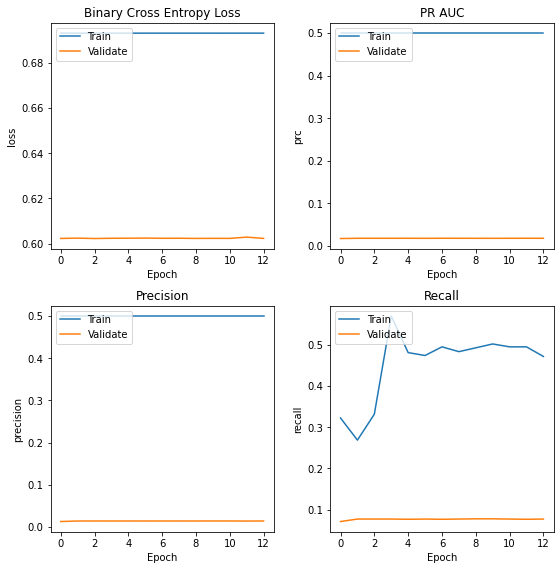

In [25]:
ev.plot_history(history)

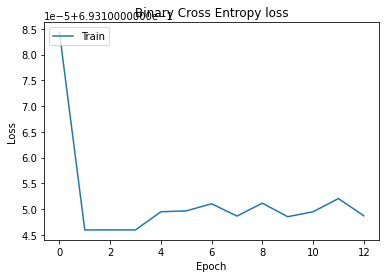

In [26]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

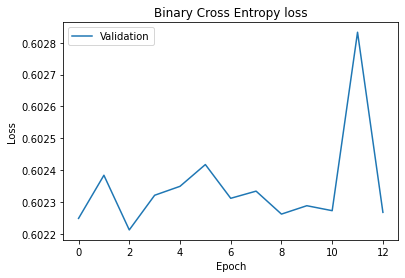

In [27]:
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

### Increase learning rate to 0.01

In [28]:
LEARNING_RATE = 0.01

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 512, 512, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 sequential_3 (Sequential)   (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_512_classratio_adam-lr-1e-2-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 40,
    validation_data=val_gen,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-13 09:14:53.144070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.6949 - tp: 12555.0000 - fp: 13323.0000 - tn: 20838.0000 - fn: 14980.0000 - accuracy: 0.5413 - precision: 0.4852 - recall: 0.4560 - auc: 0.5710 - prc: 0.4801

2023-04-13 09:32:40.237619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.50724, saving model to models/inception_imagenet_checkpoint/imagenet_512_classratio_adam-lr-1e-2-01-prc0.02-tp0.0-loss0.51.hdf5
428/428 [==============================] - 1284s 3s/step - loss: 0.6949 - tp: 12555.0000 - fp: 13323.0000 - tn: 20838.0000 - fn: 14980.0000 - accuracy: 0.5413 - precision: 0.4852 - recall: 0.4560 - auc: 0.5710 - prc: 0.4801 - val_loss: 0.5072 - val_tp: 0.0000e+00 - val_fp: 40.0000 - val_tn: 6730.0000 - val_fn: 142.0000 - val_accuracy: 0.9737 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4318 - val_prc: 0.0172
Epoch 2/100
428/428 [==============================] - ETA: 0s - loss: 0.6931 - tp: 12288.0000 - fp: 12288.0000 - tn: 15104.0000 - fn: 15104.0000 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.4486 - auc: 0.5000 - prc: 0.5000
Epoch 2: val_loss did not improve from 0.50724
428/428 [==============================] - 1244s 3s/step - loss: 0.6931 - tp: 12288.0000 - fp: 12288.0000 - tn: 15104.00

428/428 [==============================] - 1254s 3s/step - loss: 0.6936 - tp: 13568.0000 - fp: 13568.0000 - tn: 13824.0000 - fn: 13824.0000 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.4953 - auc: 0.5000 - prc: 0.5000 - val_loss: 0.5090 - val_tp: 0.0000e+00 - val_fp: 45.0000 - val_tn: 6725.0000 - val_fn: 142.0000 - val_accuracy: 0.9729 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4339 - val_prc: 0.0172
Epoch 13/100
428/428 [==============================] - ETA: 0s - loss: 0.6934 - tp: 13440.0000 - fp: 13440.0000 - tn: 13952.0000 - fn: 13952.0000 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.4907 - auc: 0.5000 - prc: 0.5000
Epoch 13: val_loss did not improve from 0.50480
428/428 [==============================] - 1252s 3s/step - loss: 0.6934 - tp: 13440.0000 - fp: 13440.0000 - tn: 13952.0000 - fn: 13952.0000 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.4907 - auc: 0.5000 - prc: 0.5000 - val_loss: 0.5074 - val_tp: 0.0000e+00 - val_fp: 40.0000 - val_

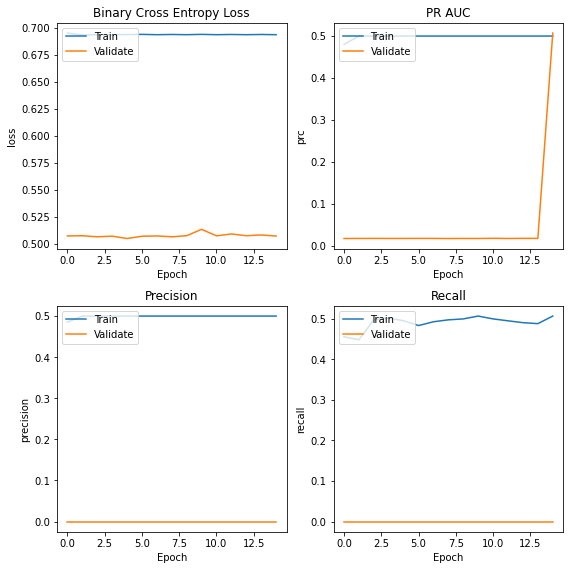

In [8]:
history={
    'loss': [0.6949, 0.6931, 0.6934, 0.6934, 0.6935, 0.6937, 0.6934, 0.6936, 0.6934, 0.6937, 0.6934, 0.6936, 0.6934, 0.6936, 0.6934],
    'prc': [ 0.4801, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
    'precision': [0.4852, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,  0.5000, 0.5000, 0.5000, 0.5000 , 0.5000],
    'recall': [0.4560, 0.4486, 0.4977, 0.5023, 0.4953, 0.4836, 0.4930, 0.4977, 0.5000, 0.5070, 0.5000, 0.4953, 0.4907, 0.4883, 0.5070],
    
    'val_loss': [0.5072, 0.5074, 0.5064, 0.5070, 0.5048, 0.5069, 0.5072, 0.5064, 0.5074, 0.5133, 0.5073, 0.5090, 0.5074, 0.5081, 0.5071],
    'val_prc': [0.0172, 0.0173, 0.0174, 0.0173, 0.0173, 0.0174, 0.0174, 0.0171, 0.0173, 0.0172,  0.0176, 0.0172, 0.0175,  0.0174,  0.5071], 
    'val_precision': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
    'val_recall': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0 , 0, 0, 0, 0]
}

metrics = ['loss', 'prc', 'precision', 'recall']
metric_name = {'loss': 'Binary Cross Entropy Loss', 'prc':'PR AUC', 'precision': 'Precision', 'recall': 'Recall'}

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
n=0
for i in range(2):
    for j in range(2):

        metric = metrics[n]
        val_metric = 'val_' + metric

        ax[i, j].plot(history[metric])
        ax[i, j].plot(history[val_metric])
        ax[i, j].set_title(metric_name[metric])
        ax[i, j].set_ylabel(metric)
        ax[i, j].set_xlabel('Epoch')
        ax[i, j].legend(['Train', 'Validate'], loc='upper left')

        n = n + 1

fig.tight_layout(pad=1) 

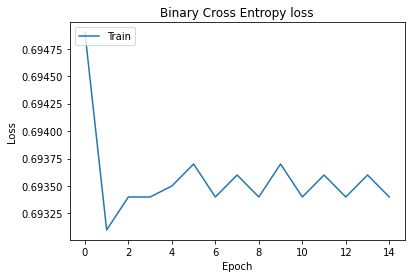

In [9]:
plt.plot(history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

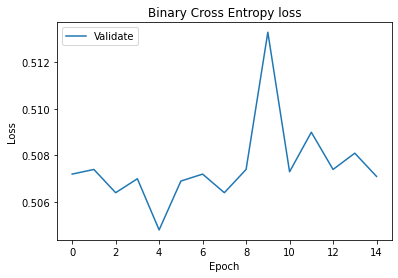

In [11]:
plt.plot(history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validate'], loc='upper left')
plt.show()

## Use initial bias and class weights

In [10]:
pos = metadata[metadata.cancer==1].image_id.nunique()
neg = metadata[metadata.cancer==0].image_id.nunique()
total = metadata[metadata.patient_id.isin(splitter.trainset.keys())].image_id.nunique()

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.33
Weight for class 1: 15.11


In [30]:
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/sgd'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/sgd
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential_4 (Sequential)   (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weight_adam-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = False,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))